<a href="https://colab.research.google.com/github/Ash100/CADD_Project/blob/main/Removal_of_Unwanted_Compounds_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Removal of the Unwanted Compounds From the Dataset**
My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TechOpenCADD project of Volkamer Lab. With some minor modifications, I tried to made it available for the students working with a Biology background. For Proper understanding and learning, you can follow the video tutorial on **Bioinformatics Insights** https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

This notebook is majorly designed for teaching purposes.

For citation and reading, https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x

##**Aims and Objectives**
In this session we will learn about the unwanted compounds or substructures. We will also learn to find them, and filtered them out.

##**Basic Concept**
Compounds with unfavourable pharmacokinetic properties are unwanted because they at times posses high reactivity or mutagenecity profiles. Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources.

Brenk et al. (Chem. Med. Chem. (2008), 3, 435-44) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.


##**Pan Assay Interference Compounds (PAINS)**
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. They show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell et al. (J. Med. Chem. (2010), 53, 2719-2740) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

**RDKit Installation**

In [ ]:
! pip install rdkit-pypi

In [2]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [3]:
# define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [ ]:
# Load the data generated in Part-2
egfr_data = pd.read_csv('/content/sample_data/ro5_properties_filtered.csv',
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Lets Draw First three molecules from the loaded dataset

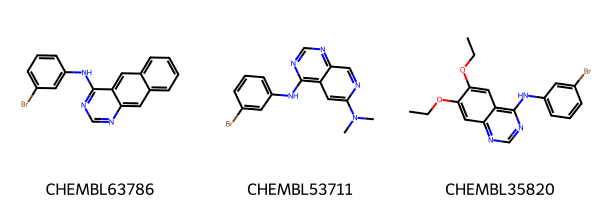

In [6]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id),
)

##PAINS Filters
PAINS filters are already embedded in RDkit- We will active and apply them on our dataset.


In [7]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

Running them on our dataset

In [ ]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

Incase you want to save the clean data

In [26]:
egfr_data.to_csv('/content/sample_data/matches.csv', index=True)

In [9]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

Number of compounds with PAINS: 490
Number of compounds without PAINS: 4941


Why not look to the three identified PAINS

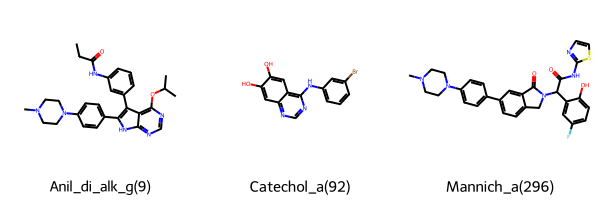

In [11]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

That is fine. Now we are going to filter and highlight unwanted substructures.
Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. Here, we use the list provided in the supporting information from Brenk et al. (Chem. Med. Chem. (2008), 3, 535-44).

In [27]:
substructures = pd.read_csv('/content/sample_data/unwanted_substructures.csv', sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


Lets have a look

In [ ]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

Now we are going to search our dataset for the unwanted substructures

In [ ]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

In case you want to save it

In [31]:
egfr_data.to_csv('/content/sample_data/matches.csv', index=False)

In [ ]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")

**Highlight substructures**
Let’s have a look at the first 3 identified unwanted substructures. Since we have access to the underlying SMARTS patterns we can highlight the substructures within the RDKit molecules.

In [ ]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

Statistics for Substructures

In [ ]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

Detected substructures can be handled in two different fashions:

Either, the substructure search is applied as a filter and the compounds are excluded from further testing to save time and money.

Or, they can be used as warnings, since ~5 % of FDA-approved drugs were found to contain PAINS (ACS. Chem. Biol. (2018), 13, 36-44). In this case experts can judge manually, if an identified substructure is critical or not.